In [2]:
! pip install numpy
! pip install networkx
! pip install pgmpy|
! pip install ipdb
! pip install yfinance
! pip install matplotlib
! pip install arviz
! pip install pymc
! pip install bambi
! pip install pyreadline


/usr/bin/sh: 1: Syntax error: end of file unexpected


In [1]:
import networkx
import pickle
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pickle
import matplotlib.pyplot as plt
from pprint import pprint
import bambi as bmb
import xarray as xr
from StockEngine import StockEngine
from tqdm import tqdm
import ipdb

%config IPCompleter.greedy=True


In [3]:
def predictions_vol_file(tday):
    return f"predictions/{tday}_vol.pkl"

def predictions_corr_file(tday):
    return f"predictions/{tday}_corr.pkl"

with open("adj_mat.pkl", "rb") as f:
    G = pickle.load(f)
    
G.remove_node('DVA')
G.remove_node('ULTA')

tickers = list(G.nodes())

# UNCOMMENT IN FUTURE
# tickers = tickers[:5]

ticker_to_index = {}
for i, ticker in enumerate(tickers):
    ticker_to_index[ticker] = i
print(tickers)
print(ticker_to_index)
num_tickers = len(tickers)
corr_len = num_tickers * (num_tickers - 1) // 2

start_date = "2010-01-01"
end_date = "2021-01-01"

prediction_folder="predictions"

engine = StockEngine(tickers, start_date=start_date, end_date=end_date)

['CTSH', 'CI', 'CMS', 'ROST', 'JNJ', 'PFG', 'PAYX', 'AON', 'FIS', 'DXC', 'ROK', 'AMZN', 'ISRG', 'PNR', 'GWW', 'LNT', 'CE', 'NKE', 'MCO', 'AEP', 'TPR', 'UNH', 'NVR', 'XEL', 'TTWO', 'CMG', 'GIS', 'WST', 'CAT', 'XRAY', 'ANSS', 'QCOM', 'INTC', 'LIN', 'MU', 'GPC', 'ITW', 'EL', 'DXCM', 'COO', 'PKG', 'AMD', 'ETN', 'MHK', 'IEX', 'HON', 'MKC', 'MO', 'BIO', 'DIS', 'NFLX', 'RL', 'CSX', 'T', 'WM', 'TER', 'CRL', 'CL', 'JKHY', 'USB', 'COF', 'TFC', 'GS', 'AVB', 'UDR', 'ESS', 'HIG', 'PEAK', 'SYY', 'WAT', 'BWA', 'NEE', 'PPL', 'LLY', 'INCY', 'LVS', 'COST', 'XOM', 'SLB', 'DVN', 'WMB', 'PXD', 'EOG', 'PSA', 'TSCO', 'TAP']
{'CTSH': 0, 'CI': 1, 'CMS': 2, 'ROST': 3, 'JNJ': 4, 'PFG': 5, 'PAYX': 6, 'AON': 7, 'FIS': 8, 'DXC': 9, 'ROK': 10, 'AMZN': 11, 'ISRG': 12, 'PNR': 13, 'GWW': 14, 'LNT': 15, 'CE': 16, 'NKE': 17, 'MCO': 18, 'AEP': 19, 'TPR': 20, 'UNH': 21, 'NVR': 22, 'XEL': 23, 'TTWO': 24, 'CMG': 25, 'GIS': 26, 'WST': 27, 'CAT': 28, 'XRAY': 29, 'ANSS': 30, 'QCOM': 31, 'INTC': 32, 'LIN': 33, 'MU': 34, 'GPC': 3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 574.40it/s]


In [4]:
import datetime

num_prev_trading_days = 126
months_to_evaluate = 12 # * 10
evaluation_year_month_start = "2012-01"

In [5]:
def convert_to_lower_triangular(A, dimension):
    C = np.zeros((A.shape[0], dimension, dimension))
    B = np.zeros((dimension, dimension))
    idx = np.tril_indices_from(B, -1)
    
    for i in range(len(A)):
        C[i][idx] = A[i]
    return C

In [6]:
def reconstruct_coefficients_vol(vol, ticker):
    return (
        vol[ticker].posterior['alpha'][0][-1].to_numpy(),
        vol[ticker].posterior['betas_day'][0][-1].to_numpy(),
        vol[ticker].posterior['betas_week'][0][-1].to_numpy(),
        vol[ticker].posterior['betas_month'][0][-1].to_numpy(),
    )

def reconstruct_coefficients_corr(corr):
    return (
        corr.posterior['alpha'][0][-1].to_numpy(),
        corr.posterior['betas_day'][0][-1].to_numpy(),
        corr.posterior['betas_week'][0][-1].to_numpy(),
        corr.posterior['betas_month'][0][-1].to_numpy(),
    )

In [10]:
def make_prediction(tday, vol, corr):
    _, RVt1, RVt25, RVt626, _, xt1, xt25, xt626 = engine.get_HAR_DRD_data(tday)
    
    # Reconstruct RV_t
    predicted_RV_t = np.zeros(num_tickers)
    for ticker_index in range(num_tickers):
        ticker = tickers[ticker_index]
        
        neighbors = list(G.adj[ticker].keys())
        alpha, betas_day, betas_week, betas_month = vol[ticker]
        
        predicted_RV_t[ticker_index] += alpha
        predicted_RV_t[ticker_index] += betas_day[0] * RVt1[ticker_index]
        predicted_RV_t[ticker_index] += betas_week[0] * RVt25[ticker_index]
        predicted_RV_t[ticker_index] += betas_month[0] * RVt626[ticker_index]
        
        for i, neighbor_ticker in enumerate(neighbors):
            neighbor_ticker_index = ticker_to_index[neighbor_ticker]
            predicted_RV_t[ticker_index] += betas_day[i+1] * RVt1[neighbor_ticker_index] 
            predicted_RV_t[ticker_index] += betas_week[i+1] * RVt25[neighbor_ticker_index] 
            predicted_RV_t[ticker_index] += betas_month[i+1] * RVt626[neighbor_ticker_index] 
    
    
    # Reconstruct R_t
    alpha, betas_day, betas_week, betas_month = corr
    predicted_R_t = alpha + betas_day * xt1 + betas_week * xt25 + betas_month * xt626
    
#     print("predicted RV_t", predicted_RV_t)
#     print("predicted R_t", predicted_R_t)
    
    D_t = np.diag(np.sqrt(predicted_RV_t))
#    D_t = np.diag(np.sqrt(np.maximum(predicted_RV_t, 0)))
    R_t = np.zeros((num_tickers, num_tickers))
    R_t[np.tril_indices_from(R_t, -1)] = predicted_R_t
    
    H_t = D_t @ R_t @ D_t
    
    return H_t
    
# Old code under the assumption we had unique coeff for each :3
#     predicted_R_t = np.zeros(corr_len)
#     indices = np.tril_indices_from(np.zeros((num_tickers, num_tickers)))
#     indices_list = list(zip(new_idx[0], new_idx[1]))
#     for idx, (ticker_1_index, ticker_2_index) in enumerate(indices_list):
#         alpha, betas_day, betas_week, betas_month = reconstruct_coefficients(vol, ticker)
        
#         predicted_R_t[idx] += 
        
    

In [11]:
def loss_frobenius(cov1, cov2):
    return np.linalg.norm(cov1 - cov2, ord='fro')

2012-01-03 Loss 0.47261686338384934


 68%|█████████████████████████████████████████████████████████████████████▌                                | 249/365 [00:29<00:13,  8.33it/s]


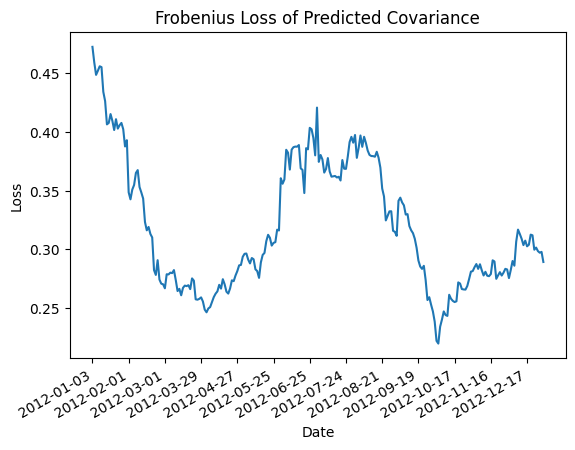

2013-01-02 Loss 0.2496735218226835


 69%|██████████████████████████████████████████████████████████████████████▏                               | 251/365 [00:30<00:13,  8.26it/s]


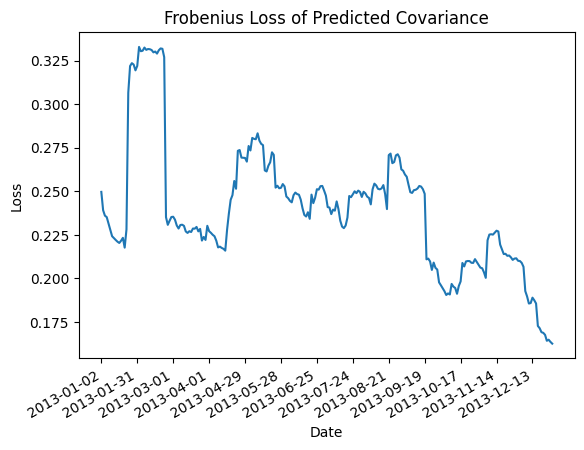

2014-01-02 Loss 0.1650295496178597


 69%|██████████████████████████████████████████████████████████████████████▏                               | 251/365 [00:29<00:13,  8.42it/s]


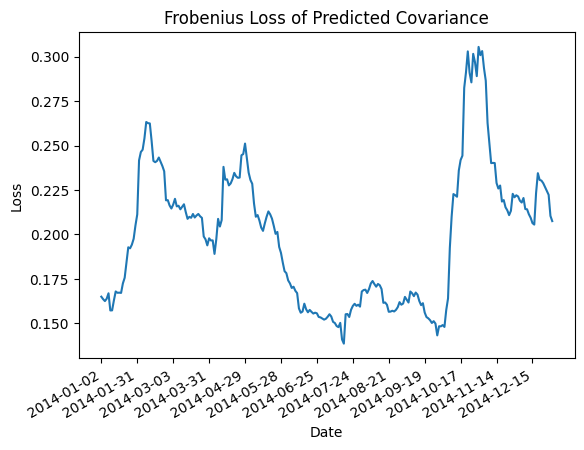

2015-01-02 Loss 0.1786196819040404


 69%|██████████████████████████████████████████████████████████████████████▏                               | 251/365 [00:32<00:14,  7.75it/s]


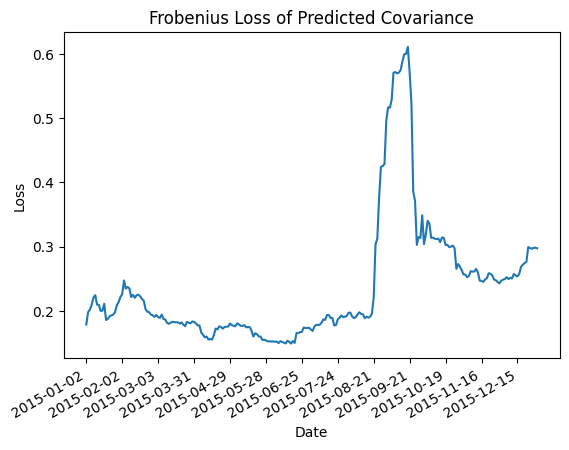

2016-01-04 Loss 0.3165313474082795


 69%|██████████████████████████████████████████████████████████████████████▏                               | 251/365 [00:29<00:13,  8.65it/s]


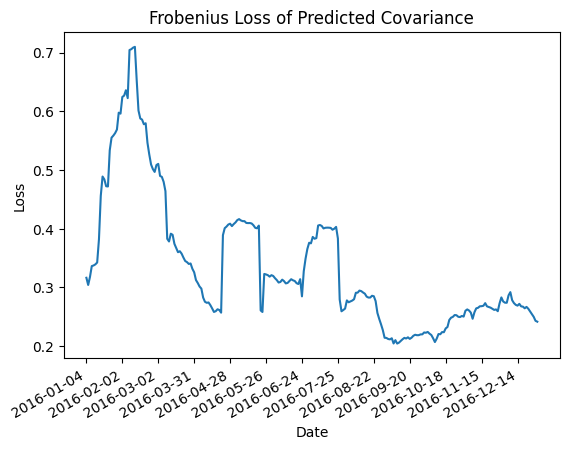

2017-01-03 Loss 0.17190832183363927


 68%|█████████████████████████████████████████████████████████████████████▊                                | 250/365 [00:29<00:13,  8.37it/s]


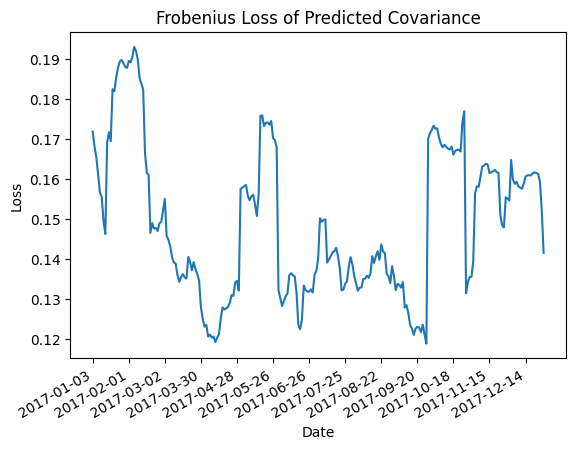

2018-01-02 Loss 0.21816302858181102


 68%|█████████████████████████████████████████████████████████████████████▊                                | 250/365 [00:30<00:14,  8.08it/s]


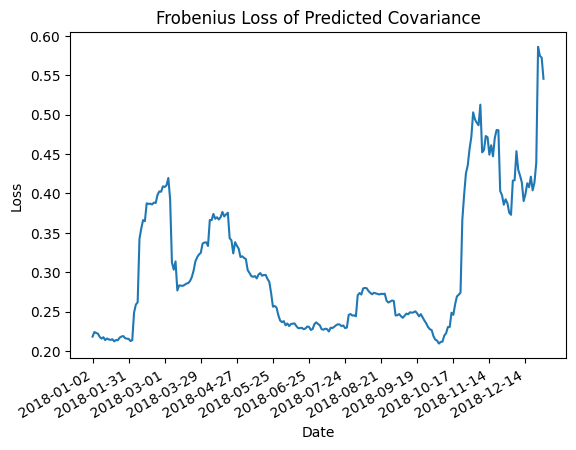

2019-01-02 Loss 0.5480360715205616


 69%|██████████████████████████████████████████████████████████████████████▏                               | 251/365 [00:31<00:14,  7.94it/s]


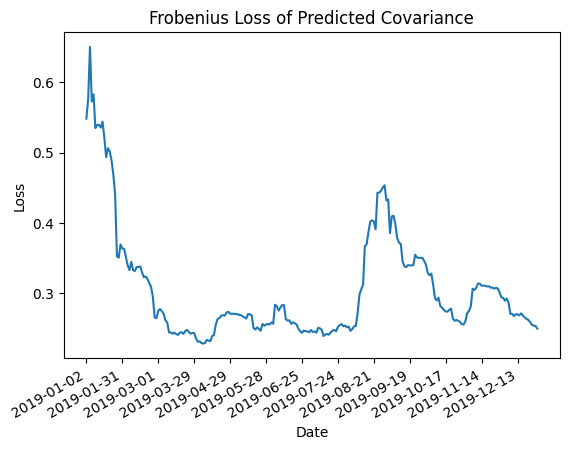

2020-01-02 Loss 0.8297886503139551


 69%|██████████████████████████████████████████████████████████████████████▍                               | 252/365 [00:28<00:12,  8.81it/s]


IndexError: list index out of range

In [47]:
import pandas as pd
import matplotlib.dates as mdates
import csv

USE_YEARLY = True

def dump_list_as_csv(data, filepath):
    with open(filepath, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for row in data:
            writer.writerow(row)

def make_yearly_prediction_starting_from(tday, vol, corr):
    start_year = tday[:4]
    timestamps = []
    losses = []
    
    for _ in tqdm(range(365)):
        predicted_H_t = make_prediction(tday, vol, corr)
        H_t, _, _, _ = engine.get_HAR_DRD(tday)
        loss = loss_frobenius(predicted_H_t, H_t)
        timestamps.append(tday)
        losses.append(loss)
        
        tday = engine.get_shift_tday(tday, 1)
        if tday[:4] != start_year:
            break
#     dates = pd.to_datetime(timestamps)

    dump_list_as_csv(zip(timestamps, losses), f"predictions/{start_year}_loss.csv")

    plt.plot(timestamps, losses)
    plt.xlabel("Date")
    plt.ylabel("Loss")
    plt.gcf().autofmt_xdate()
    plt.xticks(timestamps[0::20])
    plt.title("Frobenius Loss of Predicted Covariance")
    plt.savefig("prediction_figs/loss-" + start_year + ".png")
    plt.show()
    
    with open(f"predictions/{start_year}_loss.pkl", "wb") as f:
        pickle.dump({"timestamps" : timestamps, "losses" : losses}, f)
    
    return (timestamps, losses)

all_timestamps = []
all_losses = []
all_predicted_H_t = {}

for month_diff in range(months_to_evaluate):
    if USE_YEARLY:
        year_month = engine.get_shift_month(evaluation_year_month_start, month_diff * 12)
    else:
        year_month = engine.get_shift_month(evaluation_year_month_start, month_diff) 
        
    start_day = 1
    tday = year_month + "-{:02d}".format(start_day)
    if tday[:4] == "2021":
        break
    while tday not in engine.trading_day_list:
        start_day += 1
        tday = year_month + "-{:02d}".format(start_day) 

    with open(predictions_vol_file(tday), "rb") as f:
        vol = pickle.load(f)
    with open(predictions_corr_file(tday), "rb") as f:
        corr = pickle.load(f)
        
    predicted_H_t = make_prediction(tday, vol, corr)
    all_predicted_H_t[tday] = predicted_H_t
    H_t, _, _, _ = engine.get_HAR_DRD(tday)
    loss = loss_frobenius(predicted_H_t, H_t)
    print(f"{tday} Loss", loss)
    
    timestamps, losses = make_yearly_prediction_starting_from(tday, vol, corr)
    all_timestamps += timestamps
    all_losses += losses
    
    with open(f"evaluation/{tday}_evaluation.pkl", "wb") as f:
        pickle.dump({"predicted_H_t" : predicted_H_t,
                "H_t" : H_t,
                "loss": loss
               }, f)
    losses.append(loss)
    
with open(f"predictions/all_predicted_H_t.pkl", "wb") as f:
    pickle.dump(all_predicted_H_t, f)
    
dump_list_as_csv(zip(all_timestamps, all_losses), f"predictions/all_loss.csv")

In [51]:
with open(f"predictions/all_predicted_H_t.pkl", "wb") as f:
    pickle.dump(all_predicted_H_t, f)
    
dump_list_as_csv(zip(all_timestamps, all_losses), f"predictions/all_loss.csv")

In [52]:
all_predicted_H_t

{'2012-01-03': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02191573, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01969866, 0.0073307 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01257135, 0.00238413, 0.00187319, ..., 0.        , 0.        ,
         0.        ],
        [0.01061694, 0.00337541, 0.00244281, ..., 0.00122121, 0.        ,
         0.        ],
        [0.01011694, 0.00341221, 0.00360936, ..., 0.00110431, 0.0014563 ,
         0.        ]]),
 '2013-01-02': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01774958, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00786801, 0.00561946, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00921706, 0.00220401, 0.00109808, ..., 0.        , 0.        ,
      